# TCN Classifier

In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import sys
import numpy as np
import datetime

from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper
import ml_evaluation

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating the Network

In [4]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_features: int, num_classes: int, num_filters: int, filter_size: int, 
                 dropout_factor: float, num_blocks: int, parallel_layer: bool) -> None:
        """
        This function initializes the TemporalConvNet model
        ------
        num_features: number of features in the input
        num_classes: number of classes to predict
        num_filters: number of filters in each convolutional layer
        filter_size: size of the convolutional filter
        dropout_factor: dropout factor
        num_blocks: number of blocks of dilated convolutions
        parallel_layer: whether to add the parallel layer
        """
        super(TemporalConvNet, self).__init__()
        self.num_blocks = num_blocks
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.dropout_factor = dropout_factor
        self.parallel_layer = parallel_layer
        if self.parallel_layer:
            self.optional_layer = nn.Conv1d(num_features, num_filters, kernel_size=1)

        self.layers = nn.ModuleList()
        # Input layer
        self.layers.append(nn.Conv1d(num_features, num_filters, kernel_size=1))
        self.layers.append(nn.BatchNorm1d(num_filters))
        
        # Dilated convolutional blocks
        for i in range(num_blocks):
            dilation = 2 ** i
            # this function defines the padding and therefore teh sequence length
            pad = (filter_size - 1) * dilation // 2 
            # TODO: fix for even filter size
            self.layers.append(nn.Conv1d(num_filters, num_filters, kernel_size=filter_size, dilation=dilation, padding=pad))
            self.layers.append(nn.BatchNorm1d(num_filters))
            # if last than not dropout
            if i != num_blocks - 1:
                self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.Softmax(dim=1))

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This function defines the forward pass of the model
        ------
        x: input tensor of shape (batch_size, num_features, sequence_length)
        ------
        returns: output tensor of shape (batch_size, num_classes, sequence_length)
        """
        x_init = x.permute(0, 2, 1)
        x = x_init.clone()
        for layer in self.layers:
            x = layer(x)
        # skipped all other connections and add it at the end
        if self.parallel_layer:
            x_optional = self.optional_layer(x_init)
            x = x + x_optional

        return x

In [5]:
def train(model, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
    """
    Trains the model for the specified number of epochs
    ------
    model: TCN model
    data: DataLoader with the training data
    epochs: number of epochs to train the model
    optimizer: optimizer to use
    loss_fn: loss function to use
    ------
    Returns the training losses and accuracies
    """
    trainings_losses = []
    trainings_accuracies = []

    model.to(device)
    model.train()

    for epoch in range(epochs):
        accuracies = []
        losses = []
        for inputs, labels in data:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs.squeeze(), labels.squeeze().long())
            loss.backward()
            optimizer.step()
            
            # get accuracy
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.view(-1)
            labels = labels.view(-1)
            acc = accuracy_score(labels.cpu(), predicted.cpu())
            accuracies.append(acc)

            losses.append(loss.item())
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {round(np.mean(losses), 3)}, accuracy: {round(np.mean(accuracies), 3)}')
        trainings_losses.append(np.mean(losses))
        trainings_accuracies.append(np.mean(accuracies))
    return trainings_losses, trainings_accuracies

### Data Preparation

In [6]:
# Data preparation
organism = "E.Coli"
min_length = 100
max_length = 500
BATCH_SIZE = 32

train_dataset = ml_helper.CodonDataset(organism, "train", min_length, max_length, one_hot_aa=True)
print(f"Länge train_dataset: {len(train_dataset)}")
test_dataset = ml_helper.CodonDataset(organism, "test", min_length, max_length, one_hot_aa=True)
print(f"Länge test_dataset: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Länge train_dataset: 2284
Länge test_dataset: 592


### Hyperparameters and Model Initialization

In [7]:
# Hyperparameters
num_features = len(ml_helper.amino_acids)
num_classes = len(ml_helper.codons)  # number of codons (output classes)
num_filters = 128 #64
filter_size = 5#3  # NOTE: filter size must be unequal like: 3,5,9,...
dropout_factor = 0.008 #0.005
num_blocks = 5#2
parallel_layer = True

# Model
tcnModel = TemporalConvNet(num_features, num_classes, num_filters, filter_size, 
                        dropout_factor, num_blocks, parallel_layer)
print(tcnModel)

# Train variables
NUM_EPOCHS = 100
learing_rate = 0.001 # 0.001
criterion = nn.CrossEntropyLoss(ignore_index=64)
optimizer = optim.Adam(tcnModel.parameters(), lr=learing_rate)

TemporalConvNet(
  (optional_layer): Conv1d(22, 128, kernel_size=(1,), stride=(1,))
  (layers): ModuleList(
    (0): Conv1d(22, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.008, inplace=False)
    (5): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.008, inplace=False)
    (8): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.008, inplace=False)
    (11): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(16,), dilation=(8,))
    (12): BatchNorm1d

### Start Training

In [8]:
trainings_losses, trainings_accuracies = train(tcnModel, train_loader, NUM_EPOCHS, optimizer, criterion)

Epoch [1/100], Loss: 4.52, accuracy: 0.194
Epoch [2/100], Loss: 4.21, accuracy: 0.271
Epoch [3/100], Loss: 3.977, accuracy: 0.284
Epoch [4/100], Loss: 3.765, accuracy: 0.292
Epoch [5/100], Loss: 3.566, accuracy: 0.294
Epoch [6/100], Loss: 3.381, accuracy: 0.296
Epoch [7/100], Loss: 3.199, accuracy: 0.3
Epoch [8/100], Loss: 3.031, accuracy: 0.301
Epoch [9/100], Loss: 2.877, accuracy: 0.302
Epoch [10/100], Loss: 2.732, accuracy: 0.303
Epoch [11/100], Loss: 2.595, accuracy: 0.303
Epoch [12/100], Loss: 2.465, accuracy: 0.303
Epoch [13/100], Loss: 2.348, accuracy: 0.305
Epoch [14/100], Loss: 2.239, accuracy: 0.306
Epoch [15/100], Loss: 2.138, accuracy: 0.307
Epoch [16/100], Loss: 2.046, accuracy: 0.308
Epoch [17/100], Loss: 1.961, accuracy: 0.309
Epoch [18/100], Loss: 1.882, accuracy: 0.31
Epoch [19/100], Loss: 1.81, accuracy: 0.312
Epoch [20/100], Loss: 1.745, accuracy: 0.312
Epoch [21/100], Loss: 1.685, accuracy: 0.313
Epoch [22/100], Loss: 1.631, accuracy: 0.314
Epoch [23/100], Loss: 1.5

### Save the model

In [9]:
# timestamp
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d%H%M%S")

# save model in ml_models in a single file
torch.save(tcnModel, f"../ml_models/tcn_{organism}_model_{timestamp}.pt")
print(f"Model saved as tcn_{organism}_model_{timestamp}.pt")

Model saved as tcn_E.Coli_model_20240511141307.pt


### Load the model

In [10]:
import os
# get the newest version of the tcn model
tcnModels = os.listdir("../ml_models")
# get only tcn models
tcnModels = [model_name for model_name in tcnModels if "tcn" in model_name]
# sort by date
tcnModels.sort()
# get newest model
tcnModel_name = tcnModels[-1]
# load model
tcnModel = torch.load(f"../ml_models/{tcnModel_name}")
print(f"Model loaded: {tcnModel_name}")

Model loaded: tcn_E.Coli_model_20240511141307.pt


### Evaluation of the model

In [11]:
predicted, labels, accuracies = ml_evaluation.evaluate_model(tcnModel, device, test_loader)

In [12]:
uniq_prediction_class = ml_evaluation.get_unique_pred_classes(predicted, labels)

predicted different classes:  51 out of: 65
predicted following classes:  {0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63}


#### Get codon names and associated amino acids

In [13]:
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

predicted, labels = ml_evaluation.filter_padding(predicted, labels, filter_value=64)

predicted_codon_names =  ml_evaluation.codon_to_name(predicted)
labels_codon_names =  ml_evaluation.codon_to_name(labels)

predicted_aa =  ml_evaluation.translate_codons(predicted_codon_names)
labels_aa =  ml_evaluation.translate_codons(labels_codon_names)

ml_evaluation.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
ml_evaluation.print_unique_elements(predicted_aa, labels_aa)

predicted different classes:  51 out of: 64
predicted following classes:  {'GTC', 'TGC', 'GAG', 'CGT', 'ACT', 'AAG', 'TCA', 'CTG', 'CCA', 'GTA', 'TCC', 'GCT', 'ATT', 'GAT', 'GTT', 'GGT', 'ACA', 'CCG', 'CAG', 'ATG', 'AGC', 'AAC', 'TGG', 'GTG', 'GCA', 'CAA', 'TAC', 'CGC', 'AAT', 'GGC', 'CAC', 'CAT', 'TTT', 'CCT', 'AGT', 'ATC', 'TGA', 'AAA', 'TAA', 'GCC', 'TAT', 'ACC', 'GAA', 'TCG', 'TTC', 'GCG', 'GAC', 'ACG', 'TGT', 'TCT', 'GGG'}
predicted different amino acids:  21 out of: 21


#### Accuracies

In [14]:
# Calculate Accuracy of amino 
avg_accuracy = np.mean(accuracies)
accuracy_aa = accuracy_score(labels_aa, predicted_aa)

print('-' * 100)
print(f'Average accuracy: {avg_accuracy}')
print(f'Accuracy of amino acids: {accuracy_aa}')
print('-' * 100)

----------------------------------------------------------------------------------------------------
Average accuracy: 0.2957533783783784
Accuracy of amino acids: 1.0
----------------------------------------------------------------------------------------------------


## Plots

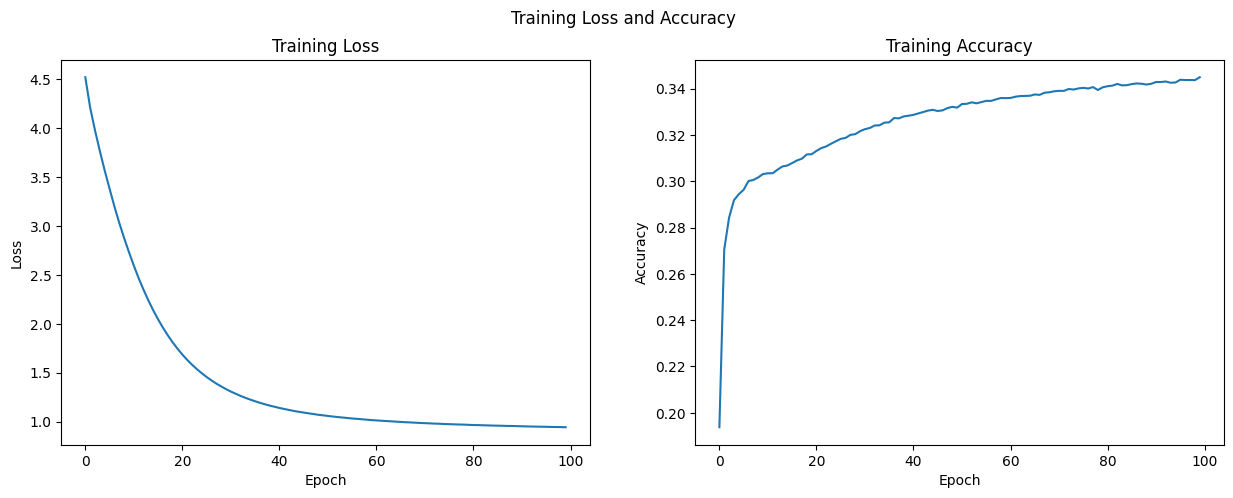

In [15]:
# plot of training loss and accuracy
plt = ml_evaluation.plot_training(trainings_losses, trainings_accuracies)
plt.show()

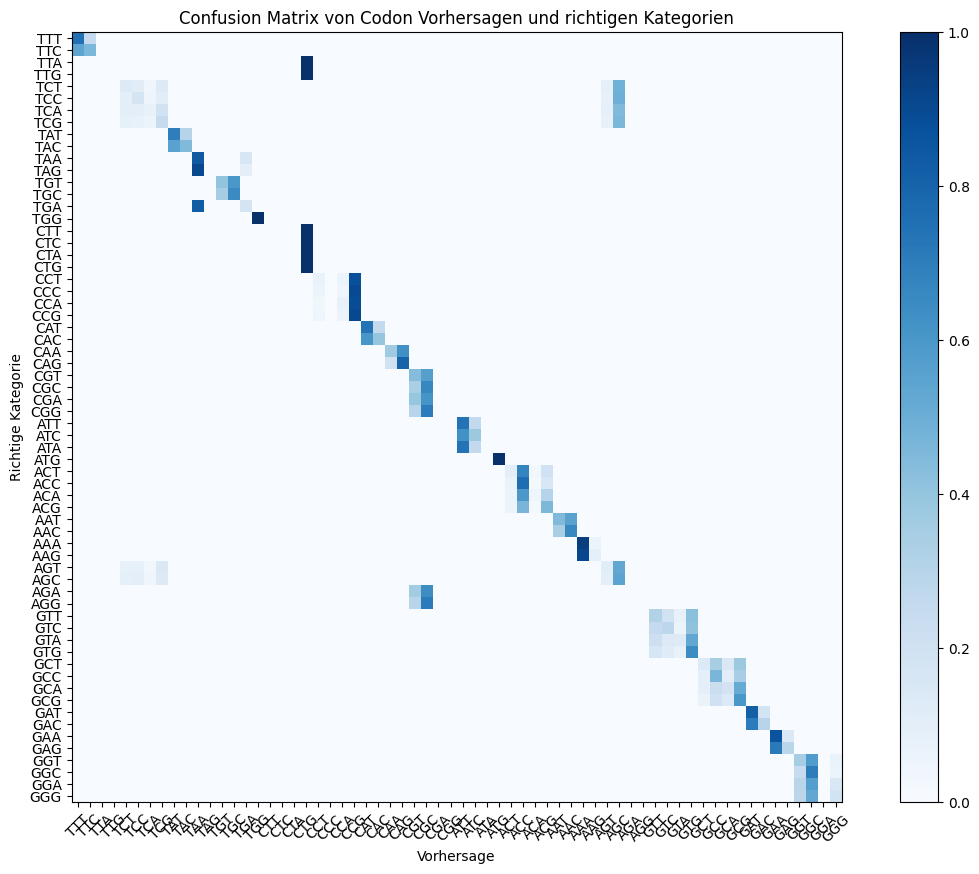

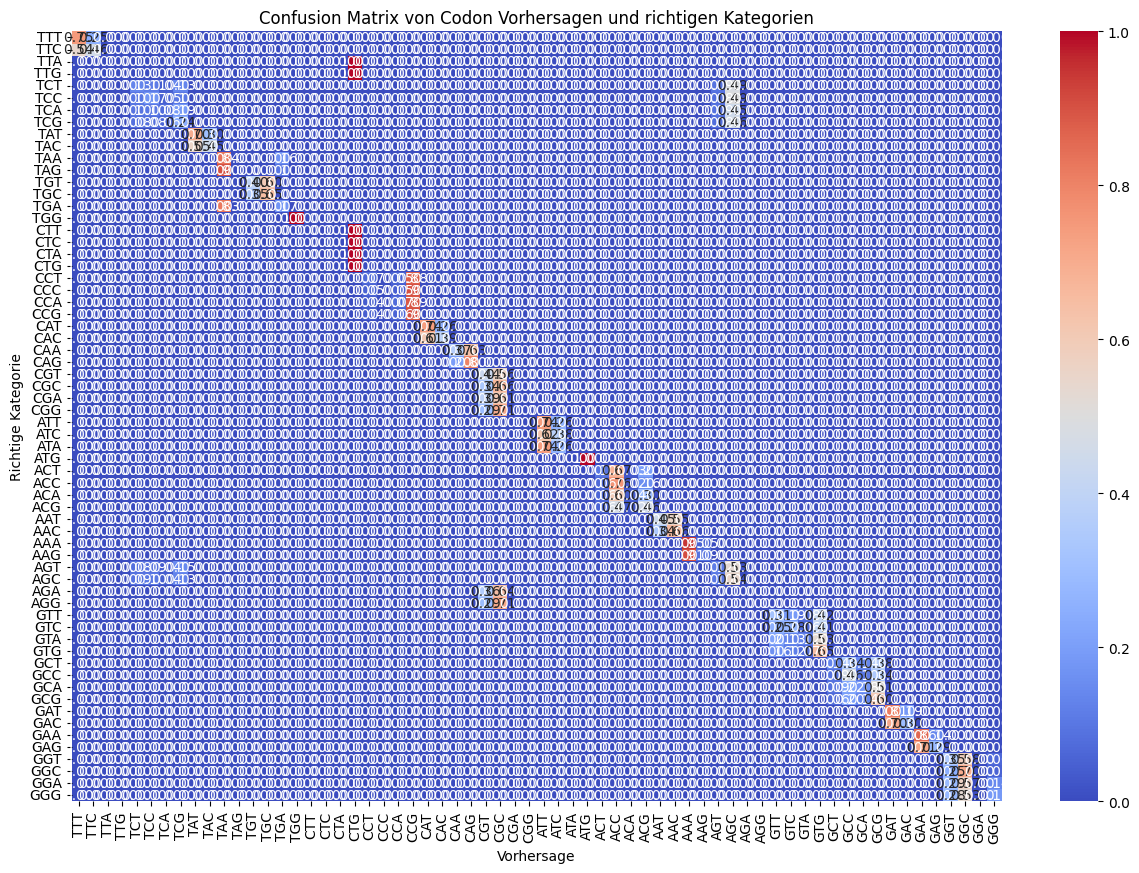

In [16]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien'

codons = [c for c in ml_helper.codons if c != '___']

plt = ml_evaluation.plot_confusion_matrix(labels, predicted, codons, title)
plt.show()
plt = ml_evaluation.plot_confusion_matrix_sns(labels, predicted, codons, title)
plt.show()

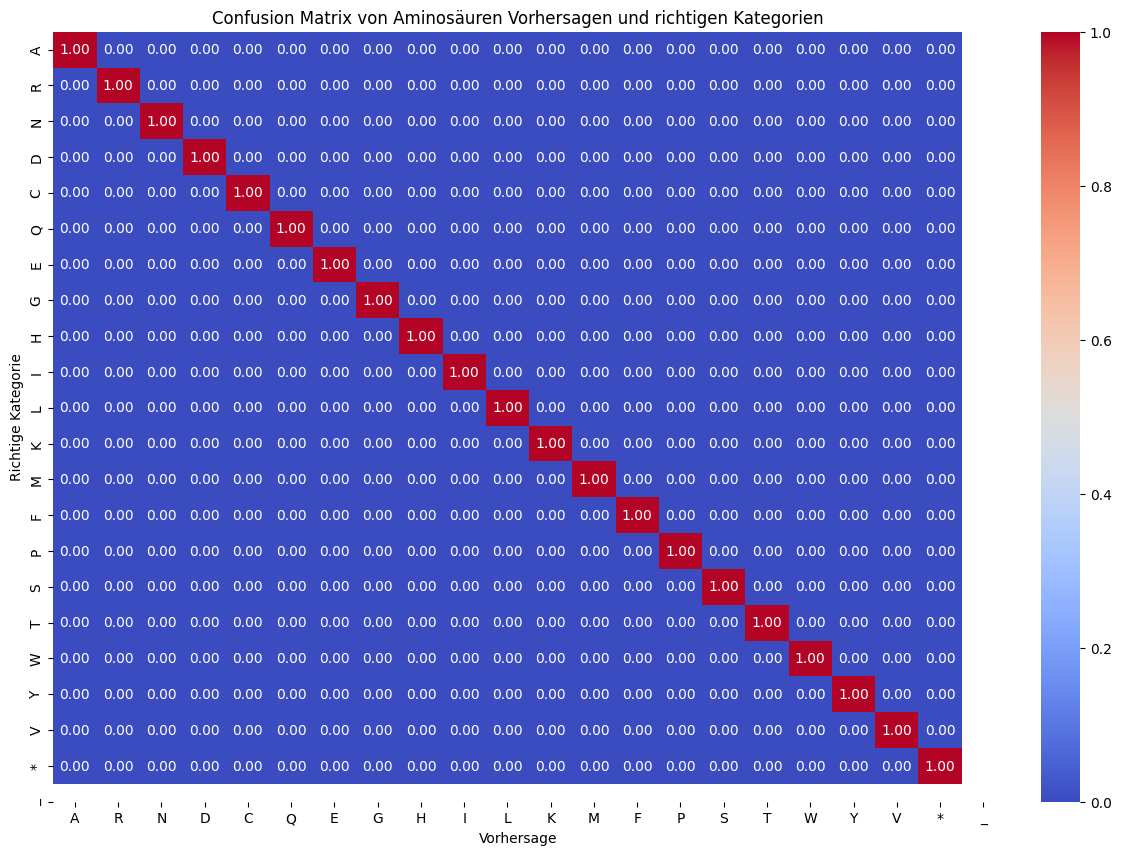

In [17]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, ml_helper.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien')
plt.show()

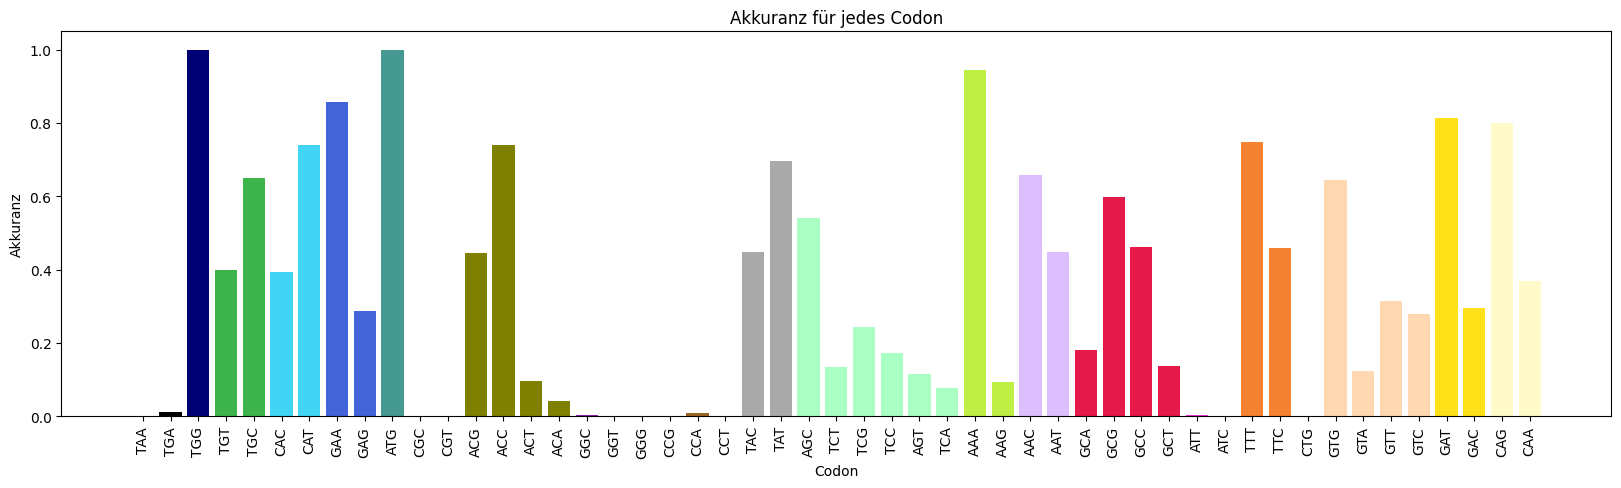

In [18]:
ml_evaluation.plot_codon_acc(labels, predicted, 'Akkuranz für jedes Codon')

M: {'ATG': 4856}
L: {'CTG': 17830, 'TTA': 0, 'TTG': 0, 'CTT': 0, 'CTC': 0, 'CTA': 0}
I: {'ATT': 7194, 'ATC': 3190, 'ATA': 0}
S: {'AGC': 4812, 'TCA': 473, 'TCC': 1026, 'TCT': 931, 'TCG': 1467, 'AGT': 898}
P: {'CCG': 6399, 'CCT': 327, 'CCA': 417, 'CCC': 0}
A: {'GCA': 2209, 'GCG': 7536, 'GCC': 4769, 'GCT': 1392}
K: {'AAA': 7021, 'AAG': 468}
T: {'ACG': 2271, 'ACC': 5705, 'ACT': 590, 'ACA': 219}
D: {'GAT': 6397, 'GAC': 1855}
Y: {'TAC': 1682, 'TAT': 2953}
Q: {'CAG': 5264, 'CAA': 1850}
R: {'CGC': 5363, 'CGT': 3230, 'CGA': 0, 'CGG': 0, 'AGA': 0, 'AGG': 0}
E: {'GAA': 7513, 'GAG': 1698}
N: {'AAC': 3946, 'AAT': 2534}
H: {'CAC': 1171, 'CAT': 2536}
G: {'GGC': 7748, 'GGT': 3679, 'GGG': 1069, 'GGA': 0}
F: {'TTT': 4399, 'TTC': 2235}
W: {'TGG': 2466}
V: {'GTG': 6158, 'GTA': 938, 'GTT': 2752, 'GTC': 2070}
*: {'TAA': 496, 'TGA': 96, 'TAG': 0}
C: {'TGT': 748, 'TGC': 1261}


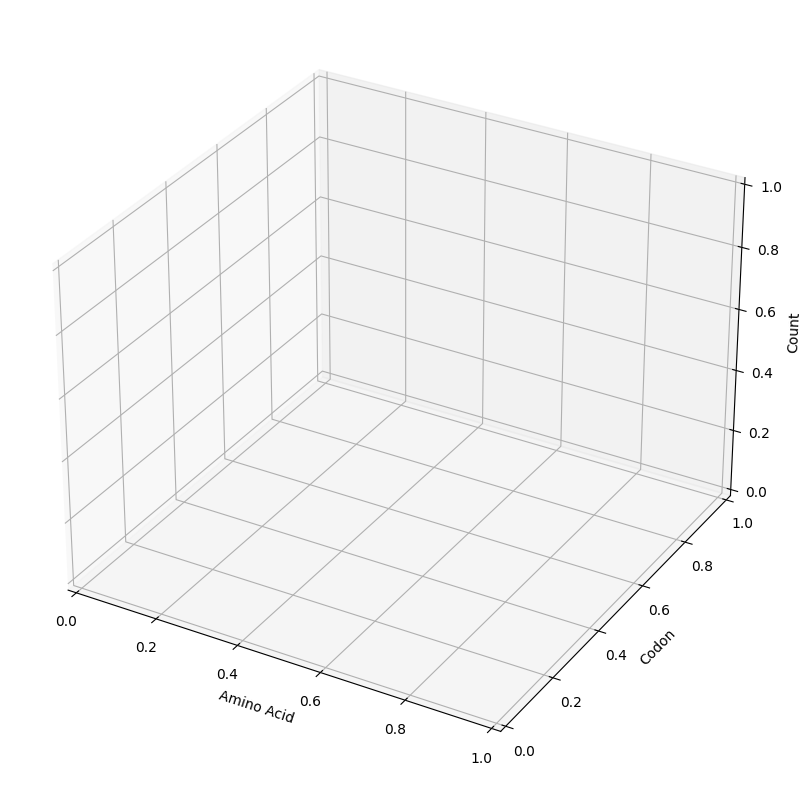

In [19]:
codon_counted = ml_evaluation.codon_count(predicted)
    # Print the counts
for amino_acid, counts in codon_counted.items():
    print(f"{amino_acid}: {dict(counts)}")

plt = ml_evaluation.plot_codon_count_3d(codon_counted)
plt.show()